# Goal

This notebook will demonstrate how to use Apache Spark to perform web log analysis. 

# Summary of Data Set

This data set comes from NASA Kennedy Space Center WWW server in Florida.

The log files are in the [Apache Common Log Format (CLF)](http://httpd.apache.org/docs/1.3/logs.html#common). The log file entries produced in CLF will look something like this:
`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`

Each part of this log entry is described below.
* `127.0.0.1`
This is the IP address (or host name, if available) of the client (remote host) which made the request to the server.
 
* `-`
The "hyphen" in the output indicates that the requested piece of information (user identity from remote machine) is not available.
 
* `-`
The "hyphen" in the output indicates that the requested piece of information (user identity from local logon) is not available.
 
* `[01/Aug/1995:00:00:01 -0400]`
The time that the server finished processing the request. The format is:
`[day/month/year:hour:minute:second timezone]`
  * day = 2 digits
  * month = 3 letters
  * year = 4 digits
  * hour = 2 digits
  * minute = 2 digits
  * second = 2 digits
  * zone = (\+ | \-) 4 digits
 
* `"GET /images/launch-logo.gif HTTP/1.0"`
This is the first line of the request string from the client. It consists of a three components: the request method (e.g., `GET`, `POST`, etc.), the endpoint (a [Uniform Resource Identifier](http://en.wikipedia.org/wiki/Uniform_resource_identifier)), and the client protocol version.
 
* `200`
This is the status code that the server sends back to the client. This information is very valuable, because it reveals whether the request resulted in a successful response (codes beginning in 2), a redirection (codes beginning in 3), an error caused by the client (codes beginning in 4), or an error in the server (codes beginning in 5). The full list of possible status codes can be found in the HTTP specification ([RFC 2616](https://www.ietf.org/rfc/rfc2616.txt) section 10).
 
* `1839`
The last entry indicates the size of the object returned to the client, not including the response headers. If no content was returned to the client, this value will be "-" (or sometimes 0).

The full data set is freely available [here](http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html).

## Parse Each Log Line

In [1]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

In [11]:
def parseLogs(logFile):
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    print 'Read {} lines, successfully parsed {} lines, failed to parse {} lines'.format(parsed_logs.count(), 
                                                                                         access_logs.count(), 
                                                                                         failed_logs.count())
    return parsed_logs, access_logs, failed_logs

parsed_logs, access_logs, failed_logs = parseLogs("data/access_log")

Read 1569898 lines, successfully parsed 1569116 lines, failed to parse 782 lines


## Statistics of Content Size

Let's compute some statistics about the sizes of content being returned by the web server.

In [15]:
from operator import add

content_sizes = access_logs.map(lambda log: log.content_size).cache()
print 'Content Size Avg: {}, Min: {}, Max: {}'.format(
    content_sizes.reduce(add) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max())

Content Size Avg: 17097, Min: 0, Max: 3421948


## Analysis of Response Code 

In [17]:
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(add)
                       .cache())
responseCodeToCountList = responseCodeToCount.collect()
print 'Found {} response codes'.format(len(responseCodeToCountList))
print 'Response Code Counts: {}'.format(responseCodeToCountList)

Found 7 response codes
Response Code Counts: [(200, 1398317), (500, 3), (501, 27), (302, 26440), (403, 171), (304, 134138), (404, 10020)]


In [18]:
labels = responseCodeToCount.keys().collect()
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()

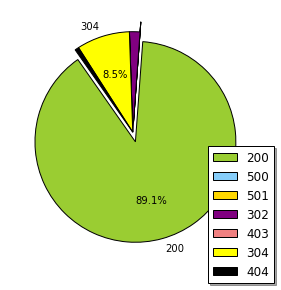

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '{:.1f}%'.format(value)

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.1, 0.1, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)

## Analysis of Host

#### Top 10 Hosts

In [29]:
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))
hostSum = hostCountPairTuple.reduceByKey(add)
hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

In [31]:
hostTop10 = hostMoreThan10.sortBy(lambda pair: -pair[1]).take(10)

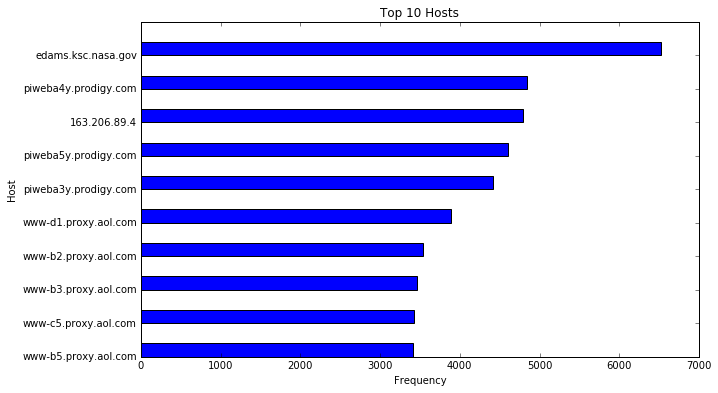

In [76]:
plt.figure(figsize=(10, 6))
plt.barh(range(18, -2, -2), [x[1] for x in hostTop10], tick_label=[x[0] for x in hostTop10])
plt.title("Top 10 Hosts")
plt.xlabel("Frequency")
plt.ylabel("Host");

#### Number of Unique Hosts

In [58]:
hosts = access_logs.map(lambda log: log.host)
uniqueHosts = hosts.distinct()
uniqueHostCount = uniqueHosts.count()
print 'Unique hosts: {}'.format(uniqueHostCount)

Unique hosts: 75050


Let's see how the number of unique hosts change on a day-by-day basis

In [59]:
dayToHostPairTuple = access_logs.map(lambda log: (log.date_time.day, log.host))
dayGroupedHosts = dayToHostPairTuple.groupByKey().mapValues(set)
dayHostCount = dayGroupedHosts.mapValues(len)
dailyHosts = (dayHostCount
              .sortByKey()
              .cache())

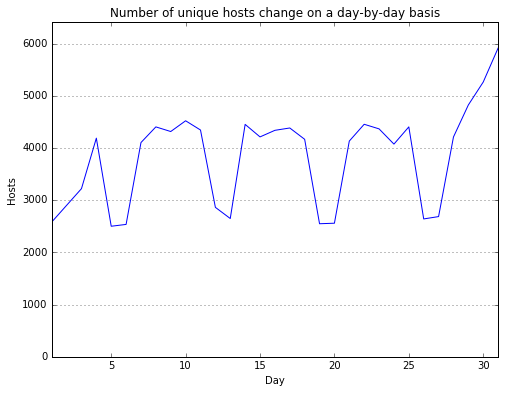

In [64]:
daysWithHosts = dailyHosts.keys().collect()
hosts = dailyHosts.values().collect()

fig = plt.figure(figsize=(8,6), facecolor='white', edgecolor='white')
plt.axis([min(daysWithHosts), max(daysWithHosts), 0, max(hosts)+500])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.title("Number of unique hosts change on a day-by-day basis")
plt.plot(daysWithHosts, hosts);

## Analysis of Endpoints

#### Top 10 Endpoints

In [49]:
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(add)
             .cache())

endpointsTop10 = endpoints.takeOrdered(10, lambda s: -1 * s[1])

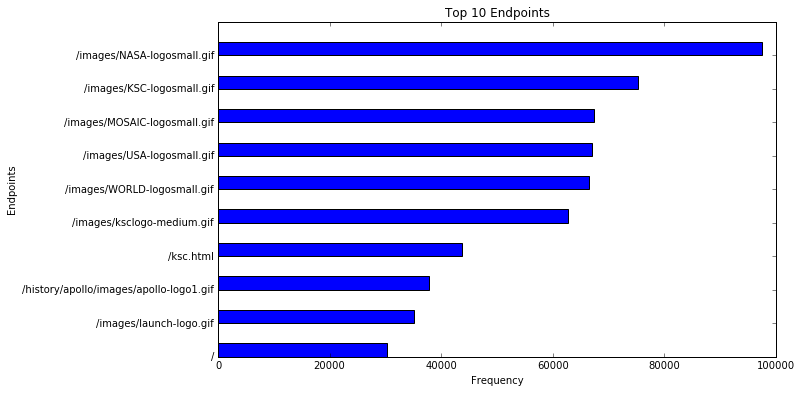

In [75]:
plt.figure(figsize=(10, 6))
plt.barh(range(18, -2, -2), [x[1] for x in endpointsTop10], tick_label=[x[0] for x in endpointsTop10])
plt.title("Top 10 Endpoints")
plt.xlabel("Frequency")
plt.ylabel("Endpoints");

#### Top 10 Error Endpoints

In [56]:
not200 = access_logs.filter(lambda log: log.response_code != 200)
endpointCountPairTuple = not200.map(lambda log: (log.endpoint, 1))
endpointSum = endpointCountPairTuple.reduceByKey(add)
errEndpointsTop10 = endpointSum.takeOrdered(10, lambda s: -1 * s[1])

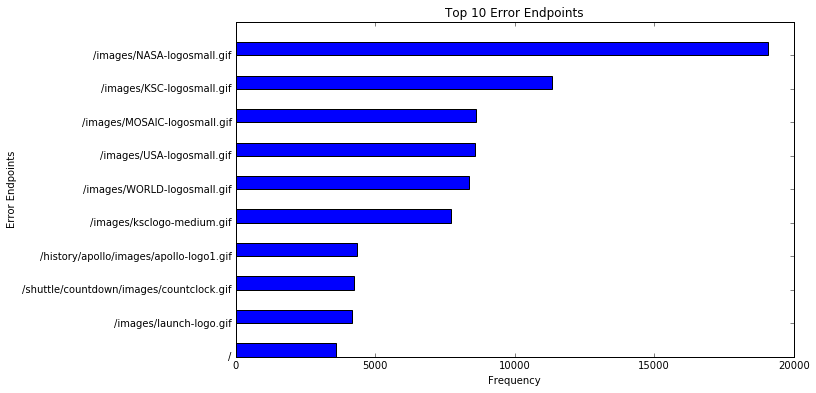

In [74]:
plt.figure(figsize=(10, 6))
plt.barh(range(18, -2, -2), [x[1] for x in errEndpointsTop10], tick_label=[x[0] for x in errEndpointsTop10])
plt.title("Top 10 Error Endpoints")
plt.xlabel("Frequency")
plt.ylabel("Error Endpoints");

## Average Daily Requests per Unique Host

In [63]:
dayAndHostTuple = access_logs.map(lambda log: (log.date_time.day, log.host))
groupedByDay = dayAndHostTuple.groupByKey()
sortedByDay = groupedByDay.sortByKey()
avgDailyReqPerHost = (sortedByDay
                      .mapValues(lambda hosts: len(hosts)/len(set(hosts)))
                      .cache())

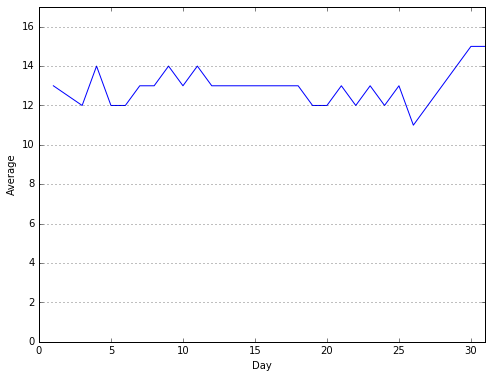

In [65]:
daysWithAvg = avgDailyReqPerHost.keys().collect()
avgs = avgDailyReqPerHost.values().collect()

fig = plt.figure(figsize=(8,6), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithAvg), 0, max(avgs)+2])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('Average')
plt.plot(daysWithAvg, avgs)

## Exploring 404

In [66]:
badRecords = (access_logs
              .filter(lambda log: log.response_code==404)
              .cache())
print 'Found {} 404 URLs'.format(badRecords.count())

Found 10020 404 URLs


#### 404 of Endpoints

In [67]:
badEndpointsCountPairTuple = badRecords.map(lambda log: (log.endpoint, 1))
badEndpointsSum = badEndpointsCountPairTuple.reduceByKey(add)
badEndpointsTop10 = badEndpointsSum.takeOrdered(10, lambda s: -1 * s[1])

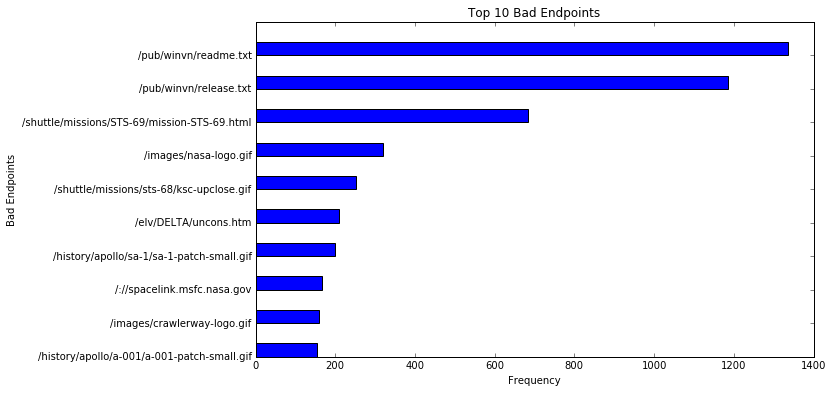

In [78]:
plt.figure(figsize=(10, 6))
plt.barh(range(18, -2, -2), [x[1] for x in badEndpointsTop10], tick_label=[x[0] for x in badEndpointsTop10])
plt.title("Top 10 Bad Endpoints")
plt.xlabel("Frequency")
plt.ylabel("Bad Endpoints");

#### 404 of Hosts

In [79]:
badHostsCountPairTuple = badRecords.map(lambda log: (log.host, 1))
badHostsSum = badHostsCountPairTuple.reduceByKey(add)
badHostsTop10 = badHostsSum.takeOrdered(10, lambda s: -1 * s[1])

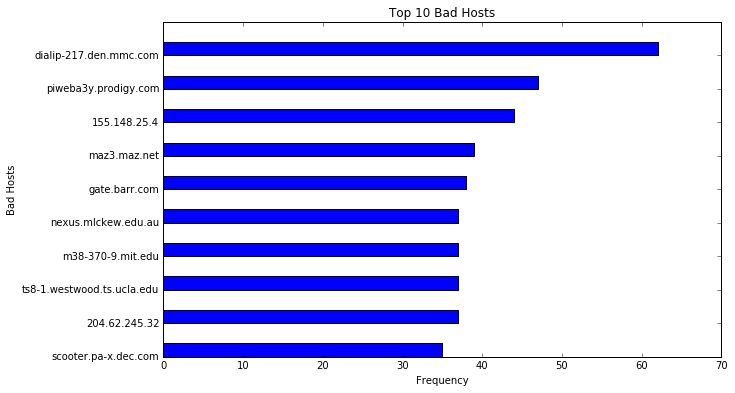

In [81]:
plt.figure(figsize=(10, 6))
plt.barh(range(18, -2, -2), [x[1] for x in badHostsTop10], tick_label=[x[0] for x in badHostsTop10])
plt.title("Top 10 Bad Hosts")
plt.xlabel("Frequency")
plt.ylabel("Bad Hosts");

#### Visualization of 404 daily changing

In [82]:
badDateCountPairTuple = badRecords.map(lambda log: (log.date_time.day, 1))
badDateSum = badDateCountPairTuple.reduceByKey(add)
badDateSorted = (badDateSum
                 .sortByKey()
                 .cache())
badByDate = badDateSorted.collect()

In [83]:
daysWithErrors404 = badDateSorted.keys().collect()
errors404ByDay = badDateSorted.values().collect()

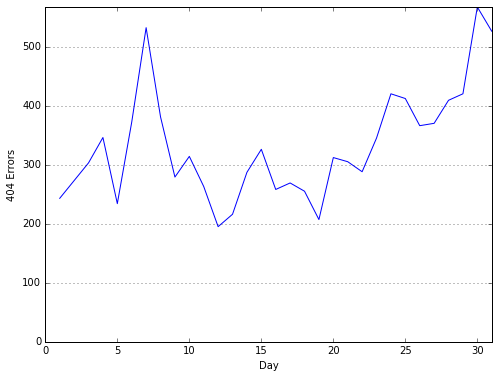

In [85]:
fig = plt.figure(figsize=(8,6), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithErrors404), 0, max(errors404ByDay)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay);